# File and libraries

In [10]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_msg_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Ecom Multichannel messages"

# DSLabs functions

In [11]:
%run "scripts/dslabs_functions.py"


# Data functions

In [12]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [13]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='is_clicked'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14668 entries, 0 to 14667
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   platform                      14668 non-null  float64
 1   email_provider                14668 non-null  float64
 2   campaign_type                 14668 non-null  float64
 3   channel_cmp                   14668 non-null  float64
 4   topic                         14668 non-null  float64
 5   total_count                   14668 non-null  float64
 6   subject_length                14668 non-null  float64
 7   day_of_year                   14668 non-null  float64
 8   month                         14668 non-null  float64
 9   hour_sin                      14668 non-null  float64
 10  hour_cos                      14668 non-null  float64
 11  min_sin                       14668 non-null  float64
 12  min_cos                       14668 non-null  float64
 13  day_of

# Distribution Check

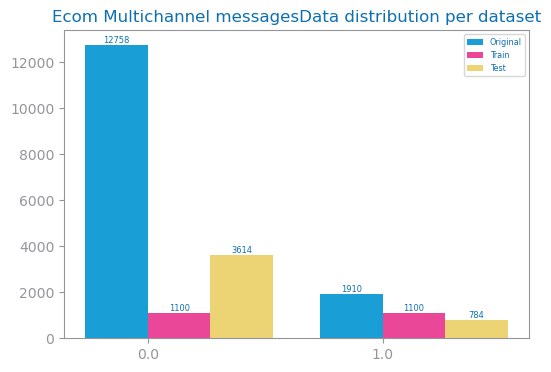

In [14]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title=f"{file_tag}Data distribution per dataset")
show()

# Model Evaluation

k80 > best f2 k29 euc
k500 > best f2 k

In [15]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')


k_eval=25 #brincar com isto lelellee 60 inicialmente

Train#=2200 Test#=4398
Labels=[0.0, 1.0]


# recall evaluation

## recall study

KNN best with k=1 and chebyshev


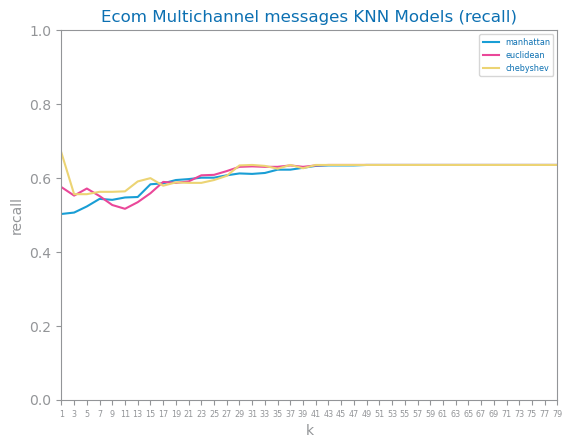

In [52]:
best_model_recall, recall_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='recall',file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["metric"]}_study.png')
show()

## recall best model

<Figure size 640x480 with 0 Axes>

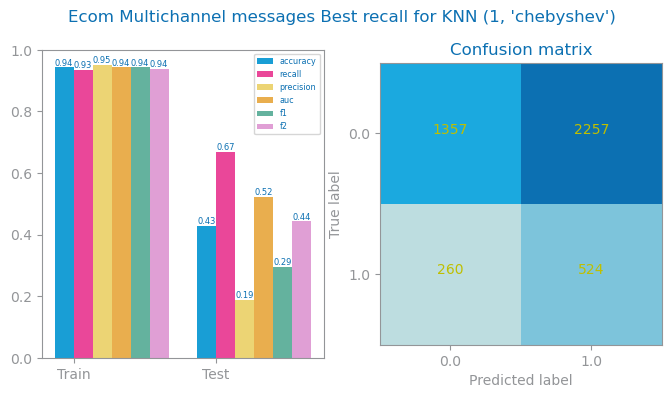

In [53]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## recall overfitting

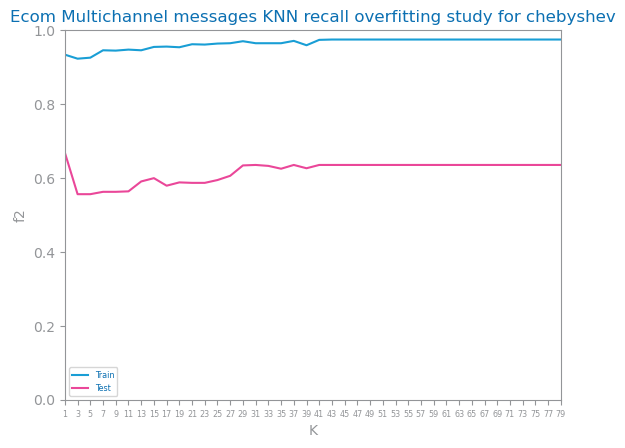

In [54]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = recall_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = recall_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {recall_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(target_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{recall_params['metric']}_overfitting.png")
show()

# precision evaluation

## precision study

KNN best with k=15 and euclidean


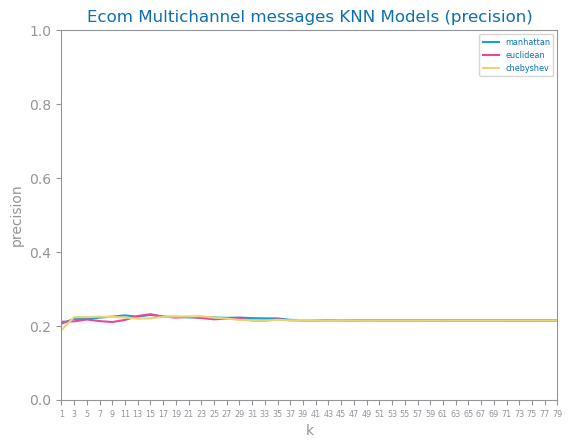

In [55]:
best_model_prec, prec_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='precision', file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{prec_params["metric"]}_study.png')
show()

## precision best model

<Figure size 640x480 with 0 Axes>

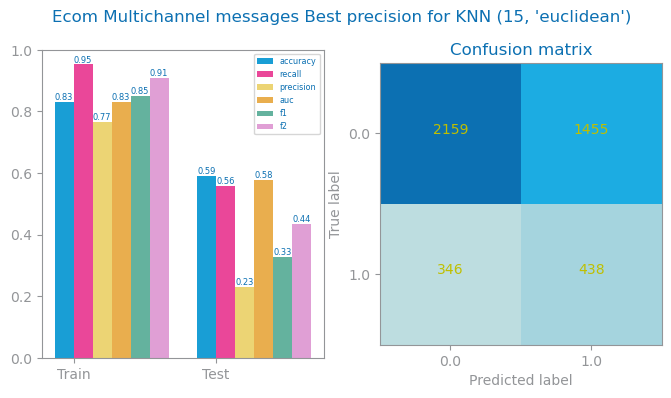

In [56]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision overfitting

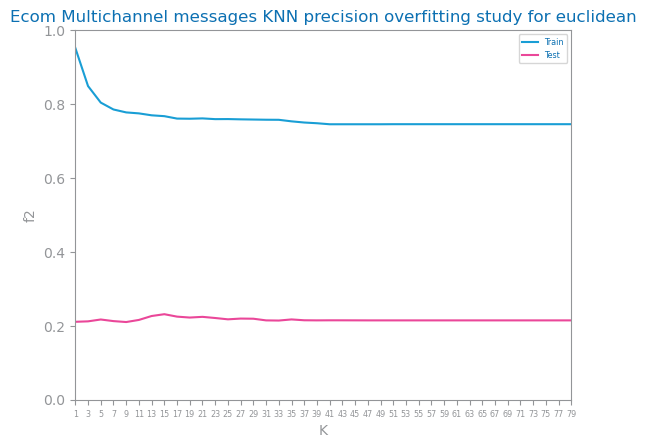

In [57]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = prec_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = prec_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {prec_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(target_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{prec_params['metric']}_overfitting.png")
show()

# f2 evaluation

## f2 Study

KNN best with k=23 and euclidean


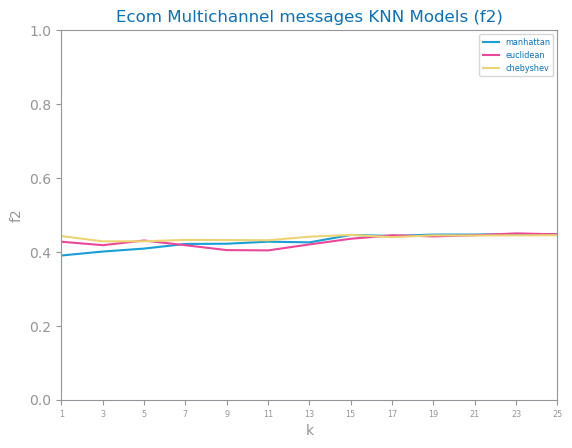

In [16]:
best_model_f2, f2_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='f2', file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{f2_params["metric"]}_study.png')
show()

## f2 best model

<Figure size 640x480 with 0 Axes>

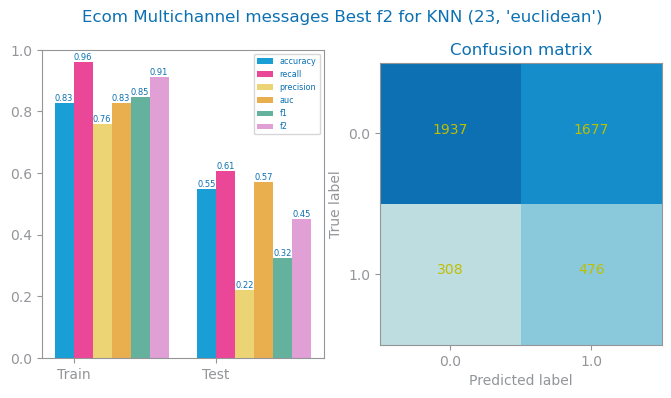

In [17]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Overfitting

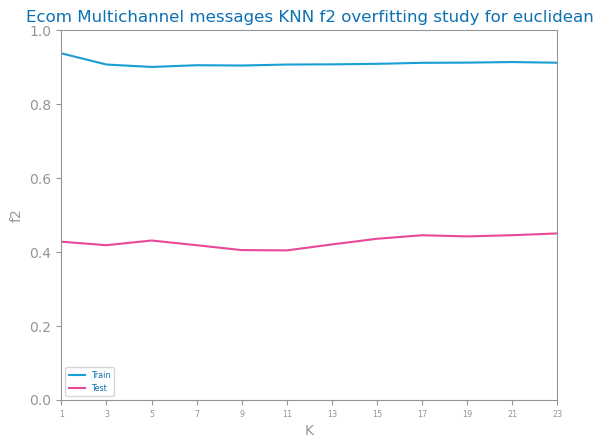

In [18]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = f2_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = f2_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {f2_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(target_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{f2_params['metric']}_overfitting.png")
show()

# Analysis

- focus on precision will not be marginally better and will predict too many negatives (both true and false) leading to a very low recall
